In [0]:
## import all the required libraries for preprocessing and computation

import re
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
##### DATASETS

In [0]:
##### LIAR
# Loading the Liar Dataset train set file
url = 'https://raw.githubusercontent.com/nishitpatel01/Fake_News_Detection/master/train.csv'
liar_df_train = pd.read_csv(url, error_bad_lines=False)

In [0]:
indexNames = liar_df_train[liar_df_train['Statement'].apply(len) > 256].index
liar_df_train.drop(indexNames , inplace=True)

In [0]:
liar_df_train['Label'].value_counts()

True     5719
False    4465
Name: Label, dtype: int64

In [0]:
liar_df_train = liar_df_train[['Statement','Label']]
liar_df_train.columns = ['text','label']
liar_df_train.columns

Index(['text', 'label'], dtype='object')

In [0]:
liar_df_train.loc[liar_df_train['label'] == True, 'label'] = 'REAL'
liar_df_train.loc[liar_df_train['label'] == False, 'label'] = 'FAKE'

In [0]:
# Loading the Liar Dataset validation set file
url = 'https://raw.githubusercontent.com/nishitpatel01/Fake_News_Detection/master/valid.csv'
liar_df_valid = pd.read_csv(url, error_bad_lines=False)

In [0]:
indexNames = liar_df_valid[liar_df_valid['Statement'].apply(len) > 256].index
liar_df_valid.drop(indexNames , inplace=True)

In [0]:
liar_df_valid.columns = ['text','label']
liar_df_valid.columns

Index(['text', 'label'], dtype='object')

In [0]:
liar_df_valid.loc[liar_df_valid['label'] == 'TRUE', 'label'] = 'REAL'
liar_df_valid.loc[liar_df_valid['label'] == 'FALSE', 'label'] = 'FAKE'

In [0]:
# Loading the liar Dataset test set file
url = 'https://raw.githubusercontent.com/nishitpatel01/Fake_News_Detection/master/test.csv'
liar_df_test = pd.read_csv(url, error_bad_lines=False)

In [0]:
liar_df_test.drop(liar_df_test[liar_df_test['Statement'].apply(len) > 256].index, inplace=True)

In [0]:
liar_df_test.columns = ['text','label']
liar_df_test.columns

Index(['text', 'label'], dtype='object')

In [0]:
liar_df_test.loc[liar_df_test['label'] == True, 'label'] = 'REAL'
liar_df_test.loc[liar_df_test['label'] == False, 'label'] = 'FAKE'

In [0]:
liar_df_test['label'].value_counts()

REAL    1371
FAKE    1167
Name: label, dtype: int64

In [0]:
# Loading the George McItyre Dataset
# fake_or_real_news.csv
url = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'
george_df = pd.read_csv(url, error_bad_lines=False)

In [0]:
indexNames = george_df[george_df['title'].apply(len) > 256].index
george_df.drop(indexNames , inplace=True)

In [0]:
### Fake News Dataset from kaggle
fnd_df = pd.read_csv('/content/gdrive/My Drive/fake_news_data_kaggle.csv',encoding='utf-8')

In [0]:
fnd_df.drop(fnd_df[fnd_df['Headline'].apply(len) > 256].index, inplace=True)

In [0]:
print(fnd_df.Headline.map(lambda x: len(x)).max())

186


In [0]:
##### Processing 
george_df = george_df[['title','text','label']]
george_df.columns
george_df['label'].value_counts()

REAL    3171
FAKE    3162
Name: label, dtype: int64

In [0]:
#### 4. Fake News Kaggle Dataset
fnd_df.tail()
fnd_df.loc[fnd_df['Label']== 0, 'Label'] = 'REAL'
fnd_df.loc[fnd_df['Label']== 1, 'Label'] = 'FAKE'
fnd_df.columns
fnd_df['Label'].value_counts()

REAL    2134
FAKE    1872
Name: Label, dtype: int64

In [0]:
#Dropping the column URLs from the table
fnd_df.drop(['URLs'], axis = 1, inplace = True)
fnd_df.columns

Index(['Headline', 'Body', 'Label'], dtype='object')

In [0]:
fnd_df.columns = ['title', 'text', 'label']

In [0]:
#### 1. LIAR Dataset
liar_df_train = liar_df_train.append(liar_df_valid, ignore_index = True)
liar_df_train = liar_df_train.append(liar_df_test, ignore_index = True)

In [0]:
liar_df_train['label'].value_counts()

REAL     8416
FAKE     6862
Label       1
Name: label, dtype: int64

In [0]:
### Cancatenating the datasets
fnd_df = fnd_df.append(george_df, ignore_index = True)
fnd_df.tail()

,title,text,label
10334,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
10335,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
10336,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
10337,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
10338,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


In [0]:
print(fnd_df.title.map(lambda x: len(x)).max())

231


In [0]:
# Taking only the title part of the dataframe
fnd_df = fnd_df[['title','label']]

In [0]:
# Changing the column so that it can concatenate with other dataframes
liar_df_train.columns = ['title','label']

In [0]:
# Concatenate the liar and the other previous datasets.
fnd_df = fnd_df.append(liar_df_train, ignore_index = True)
fnd_df.tail()

,title,label
25615,"For the first time in more than a decade, impo...",REAL
25616,Says Donald Trump has bankrupted his companies...,REAL
25617,"John McCain and George Bush have ""absolutely n...",REAL
25618,A new poll shows 62 percent support the presid...,FAKE
25619,No one claims the report vindicating New Jerse...,FAKE


In [0]:
####### Algo and Computation

# Check if GPU is Available or Not.
# Print if available. 

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# install the required bert pretrained model
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 6.7MB/s 
     |████████████████████████████████| 92kB 29.5MB/s 
     |████████████████████████████████| 645kB 41.0MB/s 


In [0]:
# if gpu is available set device equal to "cuda" else set it to "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#get the name of the GPU
torch.cuda.get_device_name(0)

'Tesla K80'

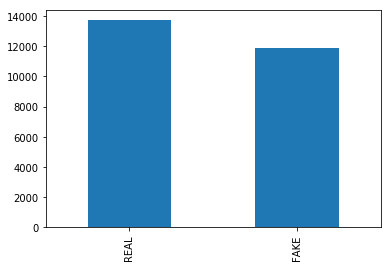

In [0]:
# Dropping that one Row having one row value as "Label"
indexNames = fnd_df[ fnd_df['label'] == "Label" ].index
indexNames
fnd_df.drop(indexNames , inplace=True)
fnd_df['label'].value_counts().plot(kind='bar')

In [0]:
# Mapping 0:FAKE
#   and   1:REAL
# fnd_df.loc[:,'senti'] = fnd_df.label.map({'FAKE':0,'REAL':1})
# fnd_df['senti'].astype(np.int64)
fnd_df['label'] = fnd_df.label.map({'FAKE':0,'REAL':1})

In [0]:
type(fnd_df['label'][0])

numpy.float64

In [0]:
fnd_df['label'].astype(np.int64)

ValueError: ignored

In [0]:
# fnd_df = fnd_df.drop(['label'], axis=1)
# fnd_df.head()

,title
0,Four ways Bob Corker skewered Donald Trump
1,Linklater's war veteran comedy speaks to moder...
2,Trump’s Fight With Corker Jeopardizes His Legi...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,Jason Aldean opens 'SNL' with Vegas tribute


In [0]:
#Get the titles
sentences = fnd_df.title.values

In [0]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 929492.64B/s]


Tokenize the first sentence:
['[CLS]', 'four', 'ways', 'bob', 'cork', '##er', 'sk', '##ew', '##ered', 'donald', 'trump', '[SEP]']


In [0]:
#loading the labels value
labels = fnd_df.label.values
labels = labels.astype(np.int64)
type(labels[0])
# type(fnd_df['senti'][0])

numpy.int64

In [0]:
# labels = labels.astype(np.int64)


In [0]:
(labels[0])


0

In [0]:
# Set the maximum sequence length.
#The longest sequence in our training set its 186
# We will set it to 256

MAX_LEN = 256

In [0]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
#Pad the sequences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
#Printing to see how the second tweet after preprocessing looks.
input_ids[1]

array([  101,  4957, 13806,  2099,  1005,  1055,  2162,  8003,  4038,
        8847,  2000,  2715,  2637,  1010,  2758,  2732,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task
# A batch size of 16 or 32 is preferred 
# If Cuda goes out of memory try lowering the batch_size.
batch_size = 15

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
# We make the num_label = 2 REAL,FAKE
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:13<00:00, 29151287.58B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
# Set different weight decays for different layers of the model.

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=3e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.21047700039078845


Epoch:  10%|█         | 1/10 [39:36<5:56:26, 2376.28s/it]

Validation Accuracy: 0.728727556596409
Train loss: 0.1438281285374651


Epoch:  20%|██        | 2/10 [1:19:12<5:16:51, 2376.39s/it]

Validation Accuracy: 0.7330210772833726
Train loss: 0.11146654093818446


Epoch:  30%|███       | 3/10 [1:58:56<4:37:29, 2378.44s/it]

Validation Accuracy: 0.731459797033568
Train loss: 0.09226015377331709


Epoch:  40%|████      | 4/10 [2:38:37<3:57:56, 2379.43s/it]

Validation Accuracy: 0.7248243559718972
Train loss: 0.07727984709746606


Epoch:  50%|█████     | 5/10 [3:18:15<3:18:14, 2378.82s/it]

Validation Accuracy: 0.7252146760343476
Train loss: 0.07570602036380669


Epoch:  60%|██████    | 6/10 [3:57:51<2:38:31, 2377.98s/it]

Validation Accuracy: 0.734192037470726
Train loss: 0.0726501691920918


Epoch:  70%|███████   | 7/10 [4:37:26<1:58:51, 2377.22s/it]

Validation Accuracy: 0.7224824355971899
Train loss: 0.0863055489038733


Epoch:  80%|████████  | 8/10 [5:17:02<1:19:13, 2376.64s/it]

Validation Accuracy: 0.7306791569086656
Train loss: 0.1889206889433516


Epoch:  90%|█████████ | 9/10 [5:56:32<39:34, 2374.88s/it]  

Validation Accuracy: 0.5132708821233413
Train loss: 0.34522909695326687


Epoch: 100%|██████████| 10/10 [6:36:08<00:00, 2375.11s/it]

Validation Accuracy: 0.7127244340359096
